# Exercise 2.2: A simple CNN for the edge lover task
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_course_2024/refs/heads/main/notebooks/art_lover.png" alt="Sample Image" width="150">

**Storytime:** 
Es gibt einen Kunstliebhaber, der nur Bilder mit vertikalen Streifen mag. Das Ziel dieses Notizbuchs ist es, einen Algorithmus (CNN) zu verwenden, der dabei hilft, zu klassifizieren, ob der Kunstliebhaber das Bild mag oder nicht.

**Aufgabe:**
Sie trainieren ein sehr einfaches CNN mit nur einem Kernel, um zwischen Bildern mit vertikalen und Bildern mit horizontalen Streifen zu unterscheiden. Um zu überprüfen, welches Muster vom trainierten Kernel erkannt wird, visualisieren Sie die Gewichte des Kernels als Bild. Sie werden sehen, dass das CNN einen nützlichen Kernel lernt (entweder einen vertikalen oder einen horizontalen Balken). Sie können mit dem Code experimentieren, um den Einfluss der Kernelgröße, der Aktivierungsfunktion und der Pooling-Methode auf das Ergebnis zu überprüfen.

**Datensatz:** Sie arbeiten mit einem künstlich generierten Datensatz aus Graustufenbildern (50 x 50 Pixel) mit 10 vertikalen oder horizontalen Streifen. Wir möchten diese Bilder danach klassifizieren, ob der Kunstliebhaber, der nur vertikale Streifen mag, das Bild mögen wird (y = 0) oder nicht mögen wird (y = 1).  

Die Idee des Notebooks ist, dass Sie versuchen, den bereitgestellten Code zu verstehen, indem Sie ihn ausführen, die Ausgabe überprüfen und damit experimentieren, indem Sie den Code leicht ändern und erneut ausführen.  

___

### 2.2.1 Datensatz generieren

Schreiben Sie eine Funktion, die einen künstlichen Datensatz aus Schwarz-Weiß-Bildern (50 x 50 Pixel) mit 10 vertikalen oder horizontalen Balken (10 Pixel lang) erstellt. Verwenden Sie diese Funktion, um einen Trainingsdatensatz mit 1000 Beispielen zu erstellen, davon 500 vertikale und 500 horizontale Beispiele. Erstellen Sie auf ähnliche Weise einen Validierungsdatensatz mit 1000 Beispielen. Normalisieren Sie die Pixelwerte so, dass sie zwischen 0 und 1 liegen.
Sie sollten die folgende Ausgabe erhalten:

```{python}
print(X_train.shape) #(1000, 50, 50, 1)
print(np.unique(Y_train)) #[0 1]
```

In [16]:
def create_img(n:int=1000, n_beam:int=10, x_dim:int=50, y_dim:int=50, line_len:int=10, line_space:bool=True, seed:int=None) -> tuple:
    """
    Create a dataset of images with vertical and horizontal lines.
    
    Parameters
    -----------
    n : int
        Number of images to create (should be even)
    n_beam : int
        Number of lines (beams) per image
    x_dim : int
        Width of the images
    y_dim : int
        Height of the images
    line_len : int
        Length of each line
    line_space : bool
        If True, ensures that lines are not adjacent to each other.
    seed : int or None
        Optional random seed for reproducibility. If provided, NumPy's RNG is seeded.
    
    Returns
    -----------
    X : np.ndarray
        Array of shape (n, x_dim, y_dim, 1) containing the images
    Y : np.ndarray
        Array of shape (n, 1) containing the labels (1 for vertical lines, 0 for horizontal lines)

    Raises
    -----------
    ValueError
        If n_beam is too large for the given image dimensions and line length.
    """
    
    import numpy as np

    # create a local random Generator for reproducibility when provided
    # using a Generator avoids altering global RNG state
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    # check if n_beam is not too large
    if line_space:
        if n_beam * 3 > min(x_dim, y_dim):
            raise ValueError("n_beam is too large for the given image dimensions and line length.")
    else:
        if n_beam > min(x_dim, y_dim):
            raise ValueError("n_beam is too large for the given image dimensions.")

    # initialize arrays (images and labels)
    X = np.zeros((n, x_dim, y_dim, 1))
    Y = np.zeros((n, 1))

    # create n/2 images with n_beam vertical lines
    for i in range((n//2)):
        x_start_list = []
        for _ in range(n_beam):
            # check if x_start is not too close to existing lines
            x_start = int(rng.integers(0, x_dim))
            while (x_start) in x_start_list or (((x_start + 1) in x_start_list or (x_start - 1) in x_start_list) and line_space):
                x_start = int(rng.integers(0, x_dim))
            x_start_list.append(x_start)
            
            y_start = int(rng.integers(0, y_dim - line_len))
            for k in range(line_len):
                X[i, x_start, y_start + k, 0] = 1.0
        Y[i] = 1.0

    # create n/2 images with n_beam horizontal lines
    for i in range((n//2), n):
        y_start_list = []
        for _ in range(n_beam):
            # check if y_start is not too close to existing lines
            y_start = int(rng.integers(0, y_dim))
            while y_start in y_start_list or (((y_start + 1) in y_start_list or (y_start - 1) in y_start_list) and line_space):
                y_start = int(rng.integers(0, y_dim))
            y_start_list.append(y_start)

            x_start = int(rng.integers(0, x_dim - line_len))
            for k in range(line_len):
                X[i, x_start + k, y_start, 0] = 1.0
        Y[i] = 0.0

    return X, Y

(1000, 50, 50, 1) (1000, 1)
[0. 1.]


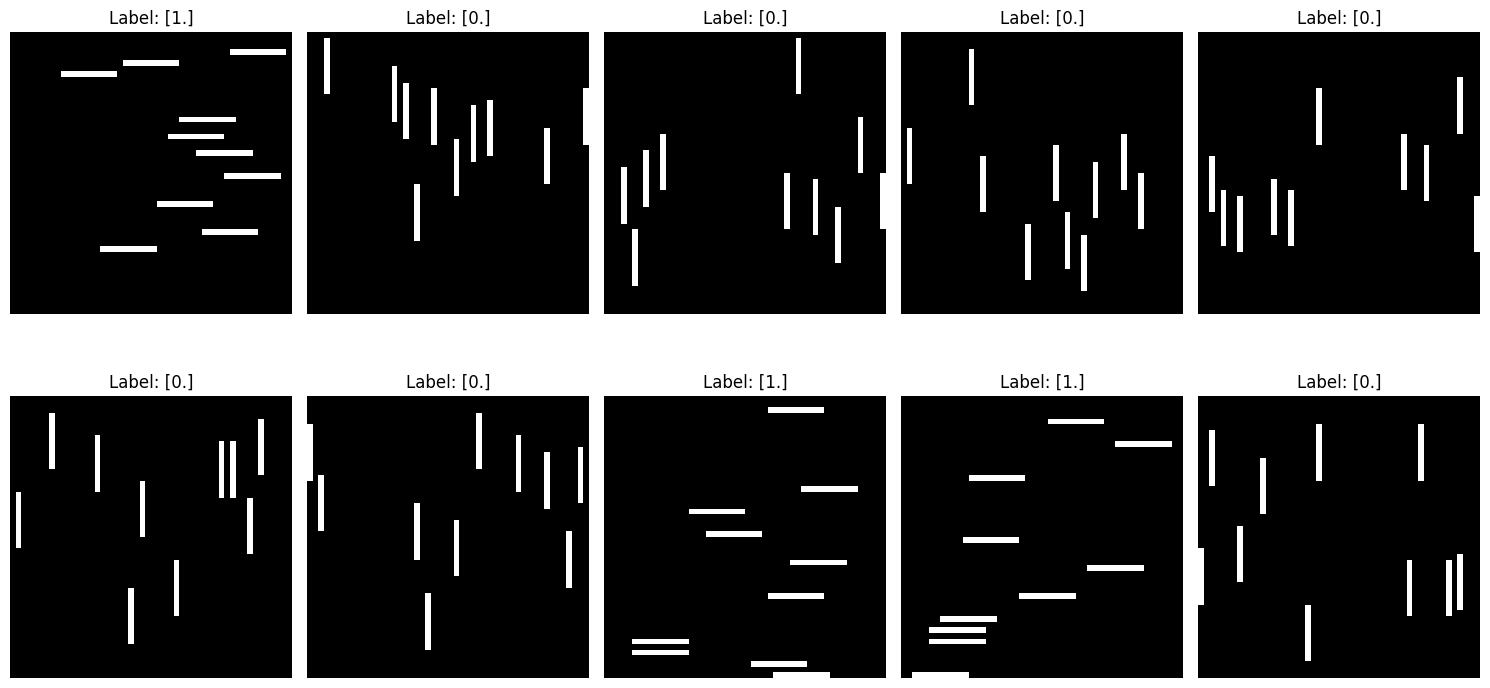

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# define seed, set to None if not used
SEED = 42

# create dataset as defined above
X_train, Y_train = create_img(1000, seed=SEED)
X_val, Y_val = create_img(1000, seed=SEED)
print(X_train.shape, Y_train.shape)
print(np.unique(Y_train))

# visualize some random samples from the dataset
id = np.random.choice(len(X_train), 10, replace=False)
# test seed function, always plot first 10 images
#id = np.arange(10)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[id[i]].reshape(50, 50), cmap='gray')
    ax.set_title(f"Label: {Y_train[id[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

___

### 2.2.2 Erstellen Sie ein möglichst einfaches CNN.

Erstellen Sie ein CNN mit einer Faltung von 5x5 (*convolution*) und einer Ausgabe. Trainieren Sie das CNN mit den Daten aus [2.2.1](#221-datensatz-generieren). Sie sollten nicht mehr als 28 trainierbare Parameter (siehe `model.summary()`) im Netzwerk haben.

* Zeichnen Sie die Lernkurven auf: (Epochen vs. Trainingsverlust und Validierungsverlust) und Epochen vs. Genauigkeit. Sie sollten eine Genauigkeit von ungefähr 1 erhalten.

**Hinweis**: Verwenden Sie die Max-Pooling-Operation auf clevere Weise.

In [18]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [19]:
import keras

# Inspect Keras/TensorFlow versions and backend
print("KERAS_BACKEND env:", os.environ.get("KERAS_BACKEND"))
print("keras.__version__:", getattr(keras, "__version__", "unknown"))
try:
    from keras.backend import backend as kb_backend
    print("keras.backend.backend():", kb_backend())
except Exception as e:
    print("keras.backend.backend() unavailable:", e)
try:
    import tensorflow as tf
    print("tensorflow.__version__:", tf.__version__)
except Exception as e:
    print("TensorFlow import failed:", e)

KERAS_BACKEND env: tensorflow
keras.__version__: 3.13.0
keras.backend.backend(): tensorflow
tensorflow.__version__: 2.20.0


In [20]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import SGD

#### Input Layer
Im ersten Schritt wird das Modell erstellt und ein Input-Layer mit der Form (50, 50, 1) definiert (50x50 Pixel, 1 Kanal für Graustufenbilder).

In [21]:
model = Sequential()

model.add(layers.InputLayer(shape=(50, 50, 1)))

#### Faltungsschicht
Anschließend wird eine Faltungsschicht mit einem 5x5-Kernel und der ReLU-Aktivierungsfunktion hinzugefügt. Das rezeptive Feld dieses Kernels ist also 5x5 Pixel groß mit welchem das Bild "gescannt" wird. Da lediglich ein Filter genutzt wird berechnet sich die Anzahl der trainierbaren Parameter wie folgt:
$$
\text{Anzahl der Parameter} = (\text{Kernelhöhe} \times \text{Kernelbreite} \times \text{Eingangskanäle} + \text{Bias}) \times \text{Anzahl der Filter}
$$
$$= (5 \times 5 \times 1 + 1) \times 1 = 26
$$

In [22]:
model.add(layers.Conv2D(1, (5, 5), activation='relu'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 1)      │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26 (104.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 0 (0.00 B)

Die Modellzusammenfassung zeigt neben der Anzahl der Parametern auch die Ausgabeformate der einzelnen Schichten an. Nach der Faltungsschicht hat das Bild die Form (46, 46, 1), da bei der Standard-Faltung die Ränder abgeschnitten werden (50 - 5 + 1 = 46). Die durch diesen Filter resultierende Feature-Map hat also eine Auflösung von 46x46 Pixeln mit einem Kanal.

Das Layer verfügt demnach über $46 \times 46 \times 1 = 2116$ Neuronen, die alle mit den 26 Parametern (25 Gewichtsparameter und 1 Bias) der Faltungsschicht verbunden sind.

#### Max-Pooling-Schicht

Pooling verändert nicht die Anzahl der Parameter, sondern die Größe der Feature-Maps und damit die Anzahl der Parameter der nächsten Schicht. Ein Pooling mit einer Fenstergröße von (4, 4) reduziert die Auflösung der Feature-Map von (46, 46, 1) auf (11, 11, 1), da jeweils 4x4 Pixel zu einem Pixel zusammengefasst werden (46/4 = 11.5, abgerundet auf 11). Die Anzahl der Neuronen in der späteren Schicht beträgt somit $11 \times 11 \times 1 = 121$. Weil jede Aktivierung ein Neuron ist und spätere Schichten sich mit diesen Neuronen verbinden brauchen und pro Verbindung ein Gewicht benötigt wird, hat die nächste Dense-Schicht entsprechend viele Eingangsgewichte.

Da lediglich maximal 28 Parameter im gesamten Netzwerk erlaubt sind, kann die Dense-Schicht nur einen Ausgangsknoten haben (1 Neuron). Daher wird ein *globales Max-Pooling* mit einer Fenstergröße von (46, 46) verwendet, um die Feature-Map auf eine Größe von (1, 1, 1) zu reduzieren. Dadurch wird die Anzahl der Neuronen in der nächsten Schicht auf 1 reduziert, was bedeutet, dass nur 2 Parameter (1 Gewicht und 1 Bias) benötigt werden.

Der so erstellte Filter reagiert auf horizontale bzw. vertikale Linien. Ist an einer Stelle im Bild eine starke Aktivierung vorhanden, so wird diese durch das Max-Pooling weitergegeben. Die Ausgabe der Max-Pooling-Schicht sagt also bereits aus, ob eine horizontale oder vertikale Linie im Bild vorhanden ist (anhand der Stärke der Aktivierung).

In [23]:
model.add(layers.MaxPooling2D((46, 46)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 1)      │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

> Eine *lokale Kontrastadaption* wie in der Vorlesung behandelt ist hier nicht notwendig, da die Bilder hier kein Rauschen enthalten und die Pixel nur die Werte 0 (schwarz) und 1 (weiß) annehmen.

#### Erklärung Dense- und Flatten-Schicht

Ein Dense Layer ist eine vollvernetzte Schicht, in der jedes Neuron mit allen Eingängen verbunden ist. In diesem Fall hat die Dense-Schicht 1 Neuron, das eine gewichtete Summe der Eingaben berechnet und eine Aktivierungsfunktion (Sigmoid) anwendet, um eine Ausgabe zwischen 0 und 1 zu erzeugen. Ein Dense Layer ist mathematisch durch die Gleichung \( y = \sigma(Wx + b) \) definiert, wobei \( W \) die Gewichtsmatrix, \( x \) der Eingabevektor, \( b \) der Bias-Term und \( \sigma \) die Aktivierungsfunktion ist.

Da es sich bei der Ausgabe der Max-Pooling-Schicht um eine 3D-Tensor mit den Dimensionen (1, 1, 1) handelt, muss dieser Tensor in einen 1D-Vektor umgewandelt werden, bevor er an die Dense-Schicht übergeben werden kann. Dies wird durch die Flatten-Schicht erreicht, die den 3D-Tensor in einen flachen Vektor umwandelt. In diesem Fall wird der Tensor (1, 1, 1) in einen Vektor mit einer einzigen Komponente umgewandelt.

Durch die Definition ergibt sich also folgendes Netzwerk:

![network_exercise_22.drawio](figures/network_exercise_22.drawio.png)

#### Netzwerktraining

Bevor das Netzwerk trainiert werden kann müssen die Daten mittels `utils.to_categorical` in ein One-Hot-Encoding umgewandelt werden, da dies für die Verwendung der `categorical_crossentropy` Verlustfunktion erforderlich ist.

In [24]:
from keras import utils
Y_train_cat = utils.to_categorical(Y_train)
Y_valid_cat = utils.to_categorical(Y_val)

history = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=10)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5000 - loss: 0.6526 - val_accuracy: 0.5000 - val_loss: 0.5700
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8180 - loss: 0.5238 - val_accuracy: 0.9800 - val_loss: 0.4788
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9980 - loss: 0.4344 - val_accuracy: 1.0000 - val_loss: 0.3928
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.3601 - val_accuracy: 1.0000 - val_loss: 0.3294
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.3047 - val_accuracy: 1.0000 - val_loss: 0.2812
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.2622 - val_accuracy: 1.0000 - val_loss: 0.2443
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.2294 - val_accuracy: 1.0000 - val_loss: 0.2151
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.2032 - val_accuracy

#### Evaluierung

Bei dem gelernten Modell handelt es sich um einen **deterministischen Klassifikator**, der entweder vertikale oder horizontale Linien erkennt. Wie in der Vorlesung behandelt bietet sich zur Evaluierung eines solchen Modells die Genauigkeit (Accuracy) sowie eine Konfusionsmatrix an.

##### Model-Accuracy (Genauigkeit)

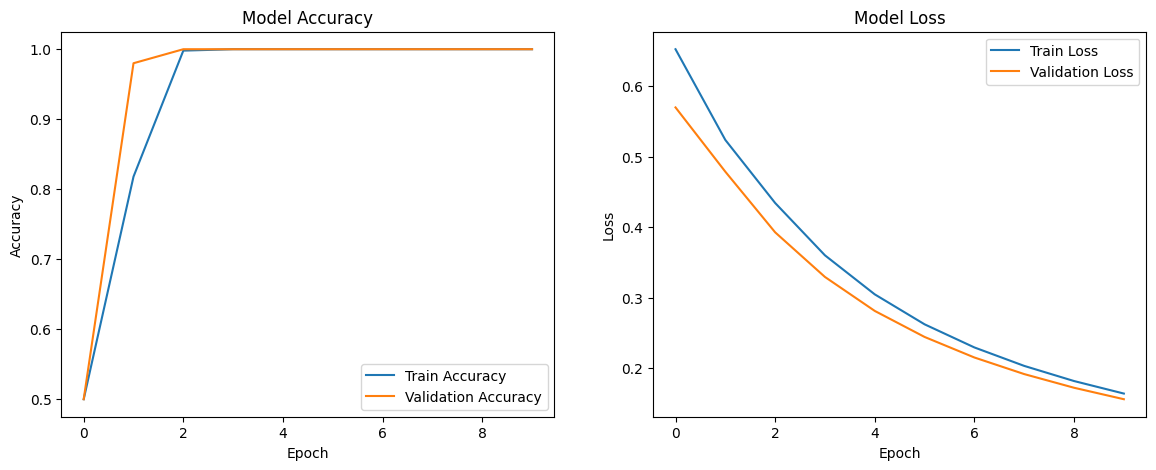

In [25]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.show()

##### Konfusionsmatrix

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


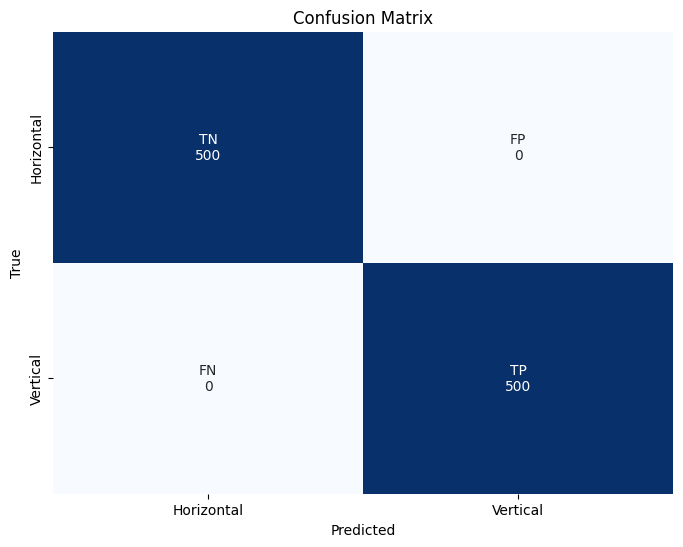

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict the labels for the validation set
Y_pred = model.predict(X_val)
Y_pred_classes = (Y_pred > 0.5).astype(int).reshape(-1)
y_true = Y_val.reshape(-1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, Y_pred_classes)

# Create annotation labels (TN, FP, FN, TP) and display counts
annot = np.empty_like(cm).astype(object)
annot[0,0] = f'TN\n{cm[0,0]}'
annot[0,1] = f'FP\n{cm[0,1]}'
annot[1,0] = f'FN\n{cm[1,0]}'
annot[1,1] = f'TP\n{cm[1,1]}'

# Plot the confusion matrix with custom annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=['Horizontal', 'Vertical'], yticklabels=['Horizontal', 'Vertical'], cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

> - TP = True Positiv (Modell sagt die positve Klasse richtig vorraus), hier: Model sagt vertikale Linie richtig vorraus
> - FP = False Positiv (Modell sagt die positive Klasse falsch vorraus/ Fehler 1. Art)
> - FN = False Negative (Modell sagt die negative Klasse falsch vorraus/ Fehler 2. Art)
> - TN = True Negative (Modell sagti die negative Klasse richtig vorraus), hier: Model sagt horizontale Linie richtig vorrauss

In [27]:
# print Precision, Recall, F1-Score
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Spezifität
recall = TP / (TP + FN) if (TP + FN) > 0 else 0     # Sensitivität
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 # F1-Score
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1_score:.4f}')

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


___

### 2.2.3 Visualisieren Sie den gelernten Kernel
Um den gelernten Kernel zu visualisieren, können Sie `model.get_weights()` verwenden. 

Ist der gelernte Kernel sinnvoll?

In [28]:
weights = model.get_weights()
print(weights[0].shape) # shape of the convolutional layer weights
print(weights[1].shape) # shape of the convolutional layer biases
print(weights[2].shape) # shape of the dense layer weights
print(weights[3].shape) # shape of the dense layer biases

(5, 5, 1, 1)
(1,)
(1, 1)
(1,)


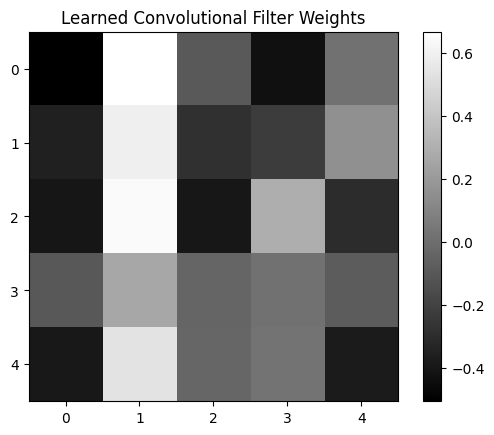

Convolutional layer biases: [-0.38275605]
Dense layer weights: [[-1.8146029]]
Dense layer biases: [1.16489]


In [29]:
conv_weights = weights[0].reshape(5, 5)

import matplotlib.pyplot as plt
plt.imshow(conv_weights, cmap='gray')
plt.colorbar()
plt.title('Learned Convolutional Filter Weights')
plt.show()

print(f"Convolutional layer biases: {weights[1]}")
print(f"Dense layer weights: {weights[2]}")
print(f"Dense layer biases: {weights[3]}")

> Wichtig: Feature Maps sind keine Bilder im klassischen Sinn, sondern Aktivierungsmuster von Filtern (hell = Filter reagiert stark, dunkel = Filter reagiert kaum)

Der Kernel zeigt in den meisten Fällen entweder einen vertikalen oder einen horizontalen Balken. Dies ist sinnvoll, da das Netzwerk darauf trainiert wurde, zwischen Bildern mit vertikalen und horizontalen Balken zu unterscheiden. Helle Bereiche im Kernel zeigen an, dass der Filter auf diese Bereiche stark reagiert, während dunkle Bereiche eine geringe Reaktion anzeigen. Aufgrund der Form des gelernten Kernels kann geschlossen werden, dass das Netzwerk gelernt hat, entweder vertikale oder horizontale Linien zu erkennen, um die Klassifikation durchzuführen.

Wichtig ist hierbei, dass die Balkenrichtung nicht relevant ist, da Filter Merkmale lernen, keine festen Richtungen. Das CNN lernt Filtergewichte automatisch durch Gradient Descent wobei sich die Filter an lokalen Strukturen orientieren, die für die Klassifikation wichtig sind. Dabei kann ein Filter Kanten horizontal oder vertikal erkennen, die Richtung wird nicht vorgegeben sondern aus den Trainingsdaten gelernt.